# Part 4: Final Transit Parameters

Import Python libraries

In [89]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee
import corner
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Upload the Excel Files containing Transit Fit Parameters

In [90]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')

Define a planetary system.

In [91]:
class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.per = per
        self.per_err = per_err
        
        self.mass = mass
        self.mass_err = mass_err
        self.radius = radius
        self.radius_err = radius_err
        
        self.teff = teff
        self.teff_err = teff_err
        self.logg = logg
        self.feh = feh
        
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. Rp needs to be in Earth radii
         
        self.u1 = 0.0 # Claret
        self.u2 = 0.0 # Claret
        self.diffld = 0.0
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.transWindow = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
          
        self.optimize4 = np.empty(0)
        
    def Print(self):
        print("Star {}".format(self.name))

Number of targets that this code will analyze

In [92]:
num = 12

About "tr_window:" Array containing estimates for transit windows (in days). To find them, I initially used a transit window of 20 hours (very big) for all the targets and plotted the folded LC. After visually inspecting it, I made my guesses. Given that these are essentially transit_range*2 (and transit_range is already in days), I chose the transit windows to be twice the range of the transit (I also estimated the range visually, so this process is not perfect. However, it's enough for the code to work and yield good results).

In [93]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.07, 0.08, 0.12, 0.15, 0.08, 0.18, 0.15])
tr_window = transit_range+transit_range # In days

In [94]:
targets = []

for i in range(0, num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    #Logg
    logg = physical["logg"][i]
    feh = physical["feh"][i]
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)

    u1 = 0.0
    u2 = 0.0
    
    # This will upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']

    trange = transit_range[i]
    twind = tr_window[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC)
    
    star.transRange = trange
    star.transWindow = twind 
     
    targets.append(star)

Get the quadratic coefficients for the standard Kepler limb-darkening profile. Model: Claret 2011. 

In [95]:
import kplr
from kplr.ld import get_quad_coeffs

def quadraticLD(star): 
    getmu1, getmu2 = get_quad_coeffs(star.teff, star.logg, star.feh)
    return getmu1, getmu2

for star in targets:
    mu1, mu2 = quadraticLD(star)
    print "Star", star.name, ":", "u1=", mu1, "u2=", mu2, "u1-u2 =", mu1-mu2
    star.u1 = mu1
    star.u2 = mu2
    star.diffld = mu1-mu2

Star 201516974 : u1= 0.7867 u2= -0.0114 u1-u2 = 0.7981
Star 201920032 : u1= 0.4089 u2= 0.2556 u1-u2 = 0.1533
Star 205924614 : u1= 0.678 u2= 0.0894 u1-u2 = 0.5886
Star 205985357 : u1= 0.4415 u2= 0.2396 u1-u2 = 0.2019
Star 206029314 : u1= 0.4906 u2= 0.1813 u1-u2 = 0.3093
Star 206038483 : u1= 0.4089 u2= 0.2556 u1-u2 = 0.1533
Star 206061524 : u1= 0.6656 u2= 0.0853 u1-u2 = 0.5803
Star 206082454 : u1= 0.3858 u2= 0.2711 u1-u2 = 0.1147
Star 206155547 : u1= 0.3277 u2= 0.2981 u1-u2 = 0.0296
Star 206245553 : u1= 0.3643 u2= 0.2807 u1-u2 = 0.0836
Star 206247743 : u1= 0.5362 u2= 0.1609 u1-u2 = 0.3753
Star 206311743 : u1= 0.5508 u2= 0.1646 u1-u2 = 0.3862


Run the code

In [96]:
def processStar(star):
    
    #Clean LC (remove points above 3 sigma)
    goodP = intro(star) 
    
    # Print old values for the period and midtransit time 
    old_per =  star.per
    old_t0 = star.midts
    print "Old period:", old_per
    print "Old t0:", old_t0
    print ""
    
    # Upload best guesses for period and overall t0    
    info = np.loadtxt('3_'+star.name+'finalp0t0.txt', skiprows=1)
    star.per = info[0,0]
    star.midts = info[1,0]
    
    #Print new values for the period and midtransit time
    print "New period: ", star.per
    print "New t0: ", star.midts
    print ""
 
   
    mark_transits(star)  #Identify transits in the data 
    transit_window(star, goodP) #Create phase-folded LC with new values of period and overall t0
    #out_transit(star)

In [97]:
def intro(star): #Clean LC (remove points above 3 sigma)
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

In [98]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -30
    maxepoch = 30
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits

In [99]:
def transit_window(star, goodP): #Select the points that are "transit_window" hours to the left & right of the transit.
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    window = star.transWindow # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0, len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans # time w.r.t. midtransit. 
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

For each individual transit: perform a linear fit to the out-of-transit regions.

In [100]:
def oot_fit(star): 
    
    corFlux = star.f_trans
    
    for i in range(0, len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            #corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
            
        else: 
            star.transits[i] = 0.0
   
    # ------- Fix length of star.transits vector (if necessary) ------- 
    
    new_a = np.empty(0)
     
    for k in range(0, len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a
    
    # ------- Fix length of star.flag, star.f_trans, star.t_trans, and star.dt vectors (if necessary)
    
    sumPoints = 0
    
    for i in range(0, len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.t_trans[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.f_trans[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.t_trans = t_trans 
    star.f_trans = f_trans 
    star.dt = dT
    
    # Divide the "light curve" of each transit by the fit obtained in the previous window.
    
    corFlux2 = star.f_trans
    
    for i in range(0, len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux2[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) 
    
    star.f_trans = corFlux2
    star.error_foldedLC = np.std(corFlux2)
    
    return err_new

In [101]:
new_targets = np.empty(0)

for i in range(0, len(targets)):    
    if (targets[i].name != "205985357") and (targets[i].name != "206038483") and (targets[i].name != "206247743") and (targets[i].name != "206311743") and (targets[i].name != "205924614"):
        new_targets = np.append(new_targets, targets[i])
        
for star in new_targets:
    print "Star ", star.name

print len(new_targets)

#  205985357: False Positive
#  206038483: Missing 2 transits....
#  206247743: False Positive 
#  206311743: False Positive
#  205924614: Wasn't working in Part 3 -- needs more investigation

Star  201516974
Star  201920032
Star  206029314
Star  206061524
Star  206082454
Star  206155547
Star  206245553
7



 ** Star  201516974 **

Old period: 36.7098909842
Old t0: 1986.80555162

New period:  36.72119335
New t0:  1986.79404608



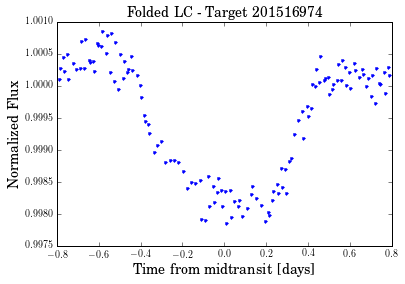

------------------------------------------------------------

 ** Star  201920032 **

Old period: 28.2716715297
Old t0: 2000.205774

New period:  28.2701484859
New t0:  2000.20594302



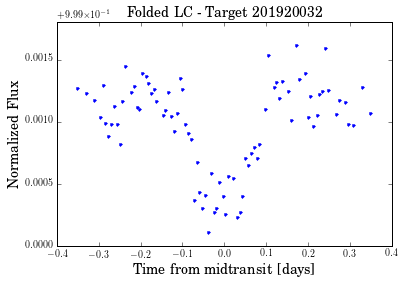

------------------------------------------------------------

 ** Star  206029314 **

Old period: 7.0260433213
Old t0: 2148.06875

New period:  7.025840132
New t0:  2148.06901109



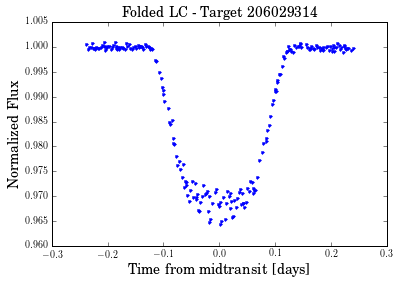

------------------------------------------------------------

 ** Star  206061524 **

Old period: 5.87969688905
Old t0: 2153.323933

New period:  5.8794161785
New t0:  2153.32428482



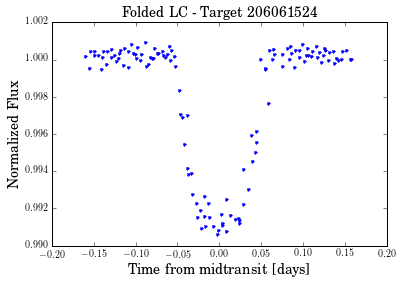

------------------------------------------------------------

 ** Star  206082454 **

Old period: 29.6259825117
Old t0: 2160.54021572

New period:  29.62608875
New t0:  2160.54007257



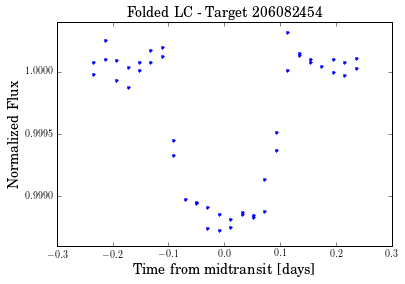

------------------------------------------------------------

 ** Star  206155547 **

Old period: 24.3872033754
Old t0: 2152.884148

New period:  24.387420177
New t0:  2152.88410258



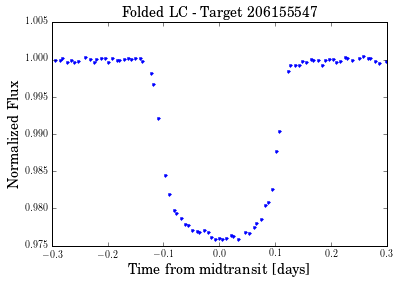

------------------------------------------------------------

 ** Star  206245553 **

Old period: 7.49495298435
Old t0: 2154.672782

New period:  7.4952243441
New t0:  2154.67369413



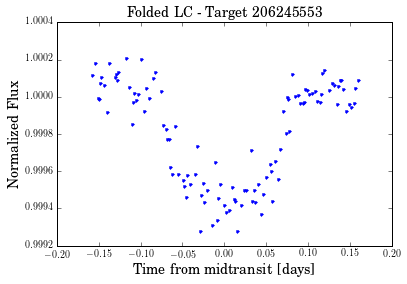

------------------------------------------------------------



In [102]:
print "WARNING: If old & new period are the same, run again the code from the beginning!"
print ""
for star in new_targets:
    print " ** Star ", star.name, "**"
    print ""
    processStar(star)
    
    # Plot the phase-folded light curve: star.dt vs. star.f_trans
    fig = plt.figure() 
    plt.plot(star.dt, star.f_trans,'.') 
    plt.title('Folded LC - Target ' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.xlabel('Time from midtransit [days]', fontsize = 14)
    plt.show()
    
    folded_time = star.dt
    folded_flux = star.f_trans
    
    argsorts = np.argsort(folded_time)
    
    folded_time = folded_time[argsorts]
    folded_flux = folded_flux[argsorts]
    
    l = len(folded_time)
    error = np.empty(l, dtype = object)
    
    for i in range(0,l):
        error[i] = 0.0001
        
    np.savetxt('4_folded' + star.name +'.csv', np.transpose([folded_time, folded_flux, error]), 
               delimiter=' ', fmt='%0.6f')
    plt.show()
    
    print "------------------------------------------------------------"
    print ""

## Fit Phase-Folded Light Curves

Likelihood function that will help me find the best transit parameters and their uncertainties



In [ ]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    """
    
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = pmass, radius = pradius ))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period = period, t0=pt0, b=np.abs(pb), e = ecc)
    s.add_body(body)
    
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp = tKep, tol = 1e-8, maxdepth = 4)
    ftheo = ftheo-1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

Define the probability function as likelihood * prior.

In [122]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    if (0 <= pb < 1.0) and (0 <= sigma) and (-0.0008 < pt0 < 0.0008) and (pradius > 0) and (0 < pmass < 2) and (0 < pdepth) and (0.3 < sumLD < 0.9):
        return 0.0
    
    return -np.inf

In [123]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

Optimization for Star 201516974 ...
-> Optimal parameters:
      Depth: 0.00246410237
      Impact parameter b: 0.87159688955
      Initial transit time: 0.00584888886
      Sum of quadratic LD coefficients: 0.72431011338
      Sigma (additional white noise term): 7.735695e-05
      Mass (Earth units): 0.00935722771
      Radius (Earth units): 1.2928083399
      Out-of-transit Flux: 1.00001605933



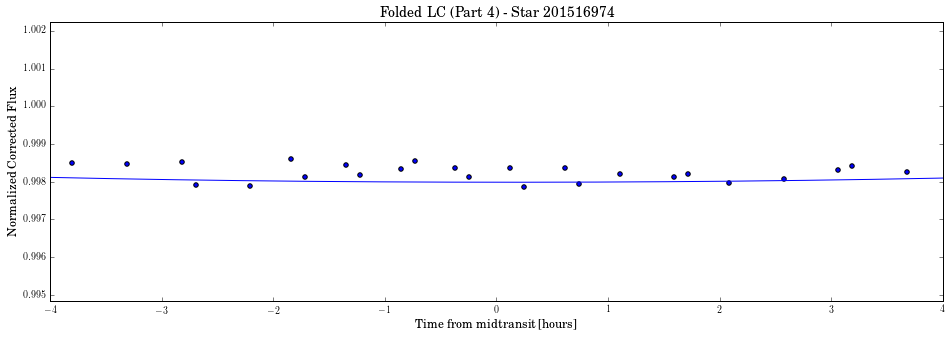

Optimization for Star 201920032 ...
Optimization terminated successfully.
         Current function value: -649.870194
         Iterations: 311
         Function evaluations: 489
-> Optimal parameters:
      Depth: 0.000614589468234
      Impact parameter b: 0.0188029015014
      Initial transit time: -0.000307875595536
      Sum of quadratic LD coefficients: 0.899998784371
      Sigma (additional white noise term): 1.82782316242e-08
      Mass (Earth units): 0.994778024692
      Radius (Earth units): 0.768699057156
      Out-of-transit Flux: 1.00018394826



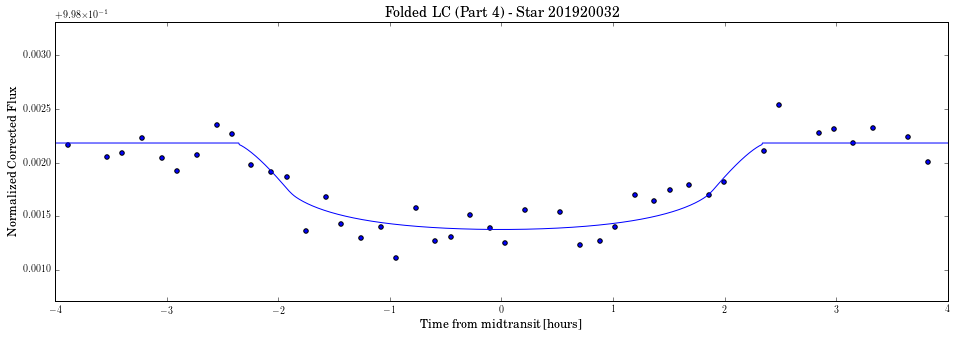

Optimization for Star 206029314 ...
-> Optimal parameters:
      Depth: 0.0263503853818
      Impact parameter b: 0.207273548904
      Initial transit time: -0.000799999621995
      Sum of quadratic LD coefficients: 0.596635332353
      Sigma (additional white noise term): 2.27506009582e-09
      Mass (Earth units): 0.741557620287
      Radius (Earth units): 1.22167067207
      Out-of-transit Flux: 0.999729780903



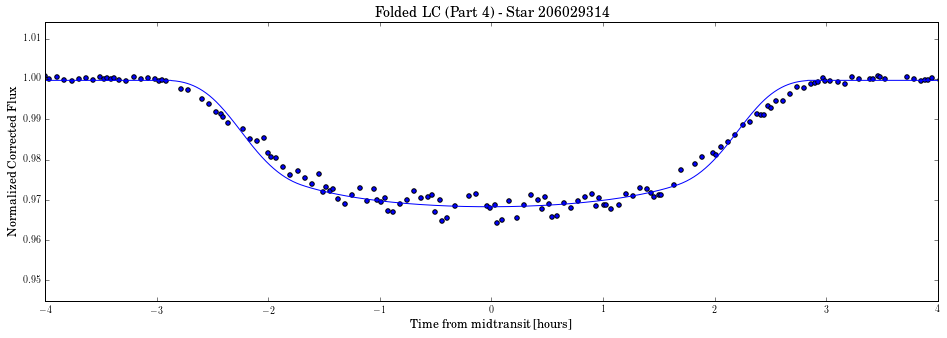

Optimization for Star 206061524 ...
Optimization terminated successfully.
         Current function value: -727.745029
         Iterations: 778
         Function evaluations: 1164
-> Optimal parameters:
      Depth: 0.00766147962943
      Impact parameter b: 0.416105165293
      Initial transit time: 0.000307696972763
      Sum of quadratic LD coefficients: 0.622822726521
      Sigma (additional white noise term): 1.42207493988e-06
      Mass (Earth units): 0.645119729183
      Radius (Earth units): 0.631321190683
      Out-of-transit Flux: 1.00021717022



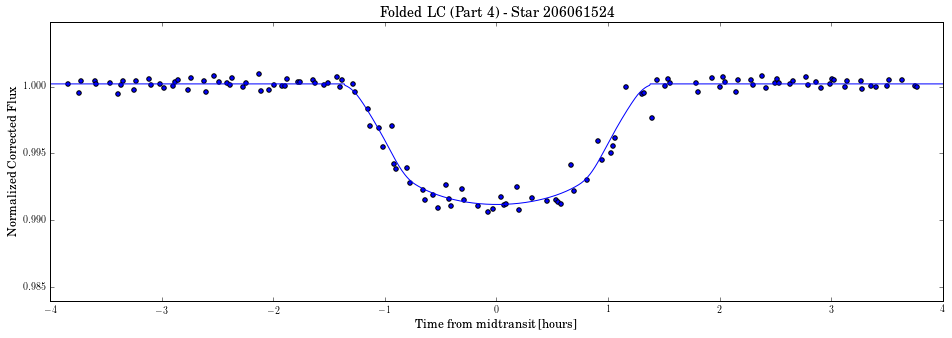

Optimization for Star 206082454 ...
Optimization terminated successfully.
         Current function value: -343.469940
         Iterations: 565
         Function evaluations: 858
-> Optimal parameters:
      Depth: 0.00110192226832
      Impact parameter b: 0.420207305488
      Initial transit time: -2.31301408503e-05
      Sum of quadratic LD coefficients: 0.65223981579
      Sigma (additional white noise term): 3.95965820871e-09
      Mass (Earth units): 0.899909454859
      Radius (Earth units): 0.891330092743
      Out-of-transit Flux: 1.00008161975



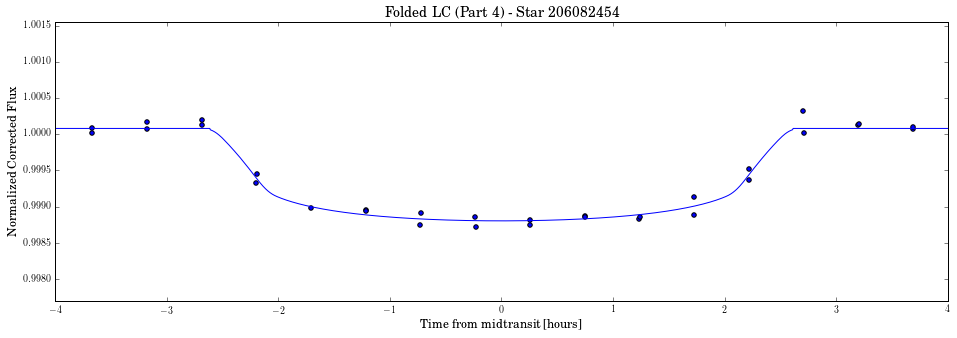

Optimization for Star 206155547 ...
Optimization terminated successfully.
         Current function value: -370.110283
         Iterations: 666
         Function evaluations: 1004
-> Optimal parameters:
      Depth: 0.0207243872768
      Impact parameter b: 0.37720677711
      Initial transit time: 0.000335009819053
      Sum of quadratic LD coefficients: 0.616184911382
      Sigma (additional white noise term): 1.85582997885e-06
      Mass (Earth units): 1.18618130522
      Radius (Earth units): 1.14615869776
      Out-of-transit Flux: 0.999959378164



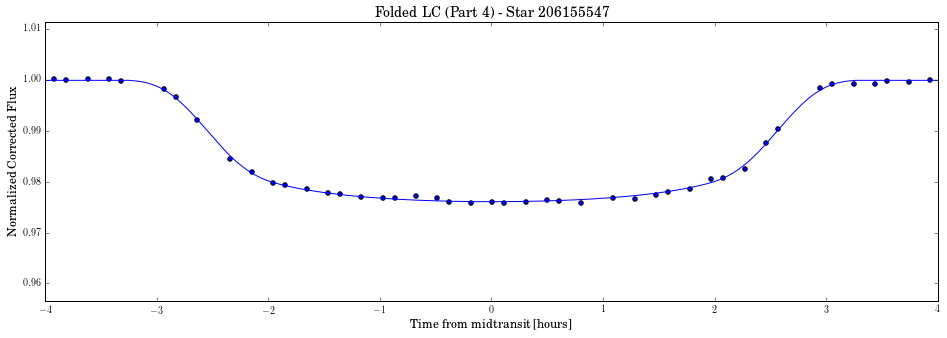

Optimization for Star 206245553 ...
-> Optimal parameters:
      Depth: 0.00048470405
      Impact parameter b: 0.23086941042
      Initial transit time: 0.00169254035
      Sum of quadratic LD coefficients: 0.71250485635
      Sigma (additional white noise term): 5.958299e-05
      Mass (Earth units): 1.05595441064
      Radius (Earth units): 1.01999788294
      Out-of-transit Flux: 0.99999885997



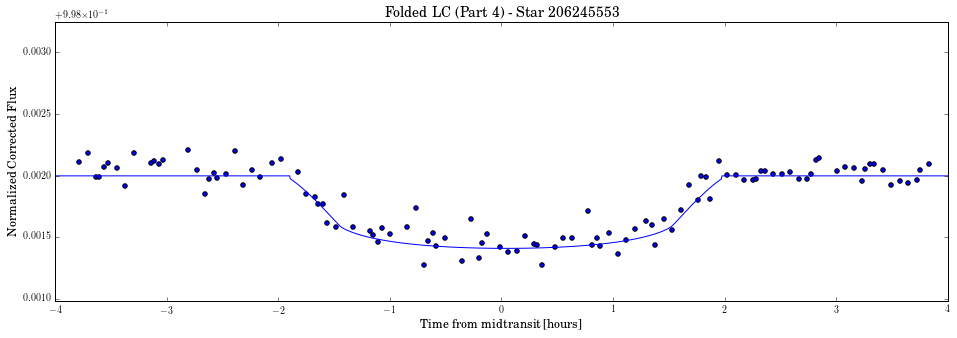

In [124]:
for star in new_targets:
    print "Optimization for Star", star.name, "..."
    
    #Upload Folded Light Curve 
    data = pd.read_table('4_folded' + star.name +'.csv', delimiter=' ', header = None, names=['time', 'flux', 'error'])
    
    t = data['time']
    f = data['flux']
    
    errorLC = np.std(f)
    star.error_foldedLC = errorLC

    meanFlux = np.mean(f)
    goodP = f<=meanFlux+3*errorLC
    
    timeLC = t[goodP] # in days
    fluxLC = f[goodP]
    
    star.dt = timeLC
    star.f_trans = fluxLC
    

    # Upload best guesses obtained in Part 1:
    parameters_ml = np.loadtxt('1_'+ star.name +'guesses.txt', skiprows=1)
    depth_ml = parameters_ml[0]
    b_ml = parameters_ml[1]
    t0_ml = parameters_ml[2]
    sigma_ml = parameters_ml[3]
    sumLD_ml = parameters_ml[4]
    mass_ml = parameters_ml[5]
    radius_ml = parameters_ml[6]
    f0_ml = parameters_ml[7]
 
    # Fixed Variables: 
    allfixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
 
    #Optimize parameters
    n3 = lambda *args: -lnprob(*args)
    result = op.minimize(n3, [depth_ml, b_ml, t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml], 
                         args = (star.dt, star.f_trans, star.error_foldedLC, allfixed), 
                         options={'disp': True}, 
                         method='Nelder-Mead')
    
    # Store and print the new best estimates 
    depth_ml2, b_ml2, t0_ml2, sigma_ml2, sumLD_ml2, mass_ml2, radius_ml2, f0_ml2 = result["x"]
    star.optimize4 = result["x"]
    
    print "-> Optimal parameters:"
    print "      Depth:", depth_ml2
    print "      Impact parameter b:", b_ml2
    print "      Initial transit time:", t0_ml2
    print "      Sum of quadratic LD coefficients:", sumLD_ml2
    print "      Sigma (additional white noise term):", sigma_ml2
    print "      Mass (Earth units):", mass_ml2
    print "      Radius (Earth units):", radius_ml2
    print "      Out-of-transit Flux:", f0_ml2
    print ""

    # np.savetxt('4_'+star.name+'initialguesses.txt', 
    #          (depth_ml2, b_ml2,  t0_ml2, sigma_ml2, sumLD_ml2, mass_ml2, radius_ml2, f0_ml2), 
    #          fmt='%.11f', delimiter='   ', header = """Input guesses obtained after fitting the phase-folded light curve (depth, 
    #          impact parameter, initial transit time, sigma (additional white noise term), mass (Earth units),
    #          radius (Earth units), out-of-eclipse flux.)""")      
    
    #Update coefficients
    u1_ml2 = 0.5*(sumLD_ml2 + star.diffld)
    u2_ml2 = sumLD_ml2-u1_ml2
    star.u1 = u1_ml2
    star.u2 = u2_ml2

    #Update other parameters
    star.mass = mass_ml2
    star.radius = radius_ml2
    star.depth = depth_ml2
    star.b = b_ml2
    
    # Compute each transit LC integrated over a Kepler long cadence exposure time with 
    #the result derived from optimization and plot theoretical model and observed data.
    
    s = transit.System(transit.Central(mu1 = star.u1, mu2 = star.u2, mass = star.mass, 
                                       radius = star.radius))
    
    body = transit.Body(r = np.sqrt(star.depth)*star.radius, period = star.per, 
                        t0 = t0_ml2, b = star.b, e = star.ecc)
    s.add_body(body)

    t_theory = np.arange(-1.5, 1.5, tKep*0.01)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-08, maxdepth = 5)
    f_theory = f_theory - 1.0 + f0_ml2

    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(24.0*star.dt, star.f_trans) #timeLC is originally in days
    plt.xlim([-4.0, 4.0]) 
    plt.ylim([1-star.depth*2.1, star.depth*0.5+1.001]) 
    ax.set_xlabel('Time from midtransit [hours]', fontsize = 12)
    ax.set_ylabel('Normalized Corrected Flux', fontsize = 12)
    plt.title('Folded LC (Part 4) - Star ' + star.name, fontsize = 14)
    ax.plot(24*t_theory, f_theory)
    plt.savefig('4_'+star.name+'foldedLC.png', dpi = 700)
    plt.show()

## Final MCMC

In [125]:
final_targets = np.empty(0)

for i in range(0, len(new_targets)):    
    if (new_targets[i].name != "201516974"): 
        final_targets = np.append(final_targets, new_targets[i])
        
for star in final_targets:
    print "Star ", star.name

print len(final_targets)

Star  201920032
Star  206029314
Star  206061524
Star  206082454
Star  206155547
Star  206245553
6


With the best fit solutions, we'll run an MCMC routine to estimate the uncertainties on the parameters.

Analysis of: 201920032
Model parameters:
      Depth: 0.000614589468234
      Impact parameter b: 0.0188029015014
      Initial transit time: -0.000307875595536
      Sigma (additional white noise term): 1.82782316242e-08
      Sum of quadratic LD coefficients: 0.899998784371
      Mass (Earth units): 0.994778024692
      Radius (Earth units): 0.768699057156
      Out-of-transit Flux: 1.00018394826

Running MCMC...
Done.


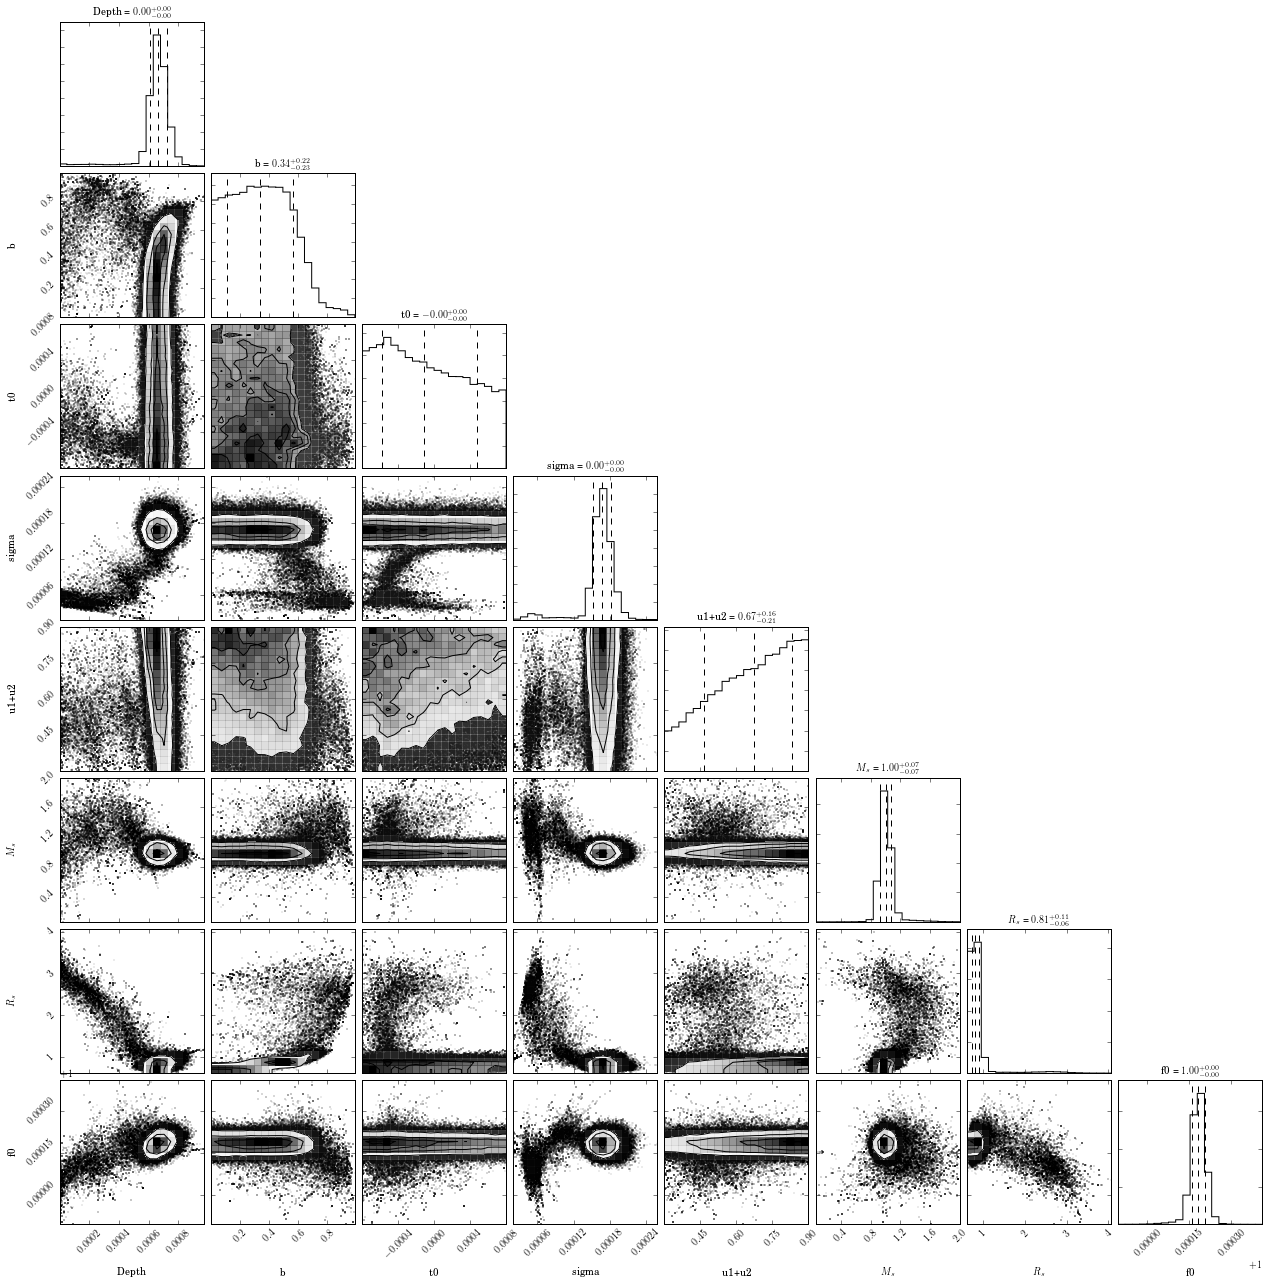

(2.2640716749036374, 0.371810945217669, 0.18265835365452032)
(0.020719129606429739, 0.0028143842181348154, 0.001398723744377009)
Analysis of: 206029314
Model parameters:
      Depth: 0.0263503853818
      Impact parameter b: 0.207273548904
      Initial transit time: -0.000799999621995
      Sigma (additional white noise term): 2.27506009582e-09
      Sum of quadratic LD coefficients: 0.596635332353
      Mass (Earth units): 0.741557620287
      Radius (Earth units): 1.22167067207
      Out-of-transit Flux: 0.999729780903

Running MCMC...
Done.


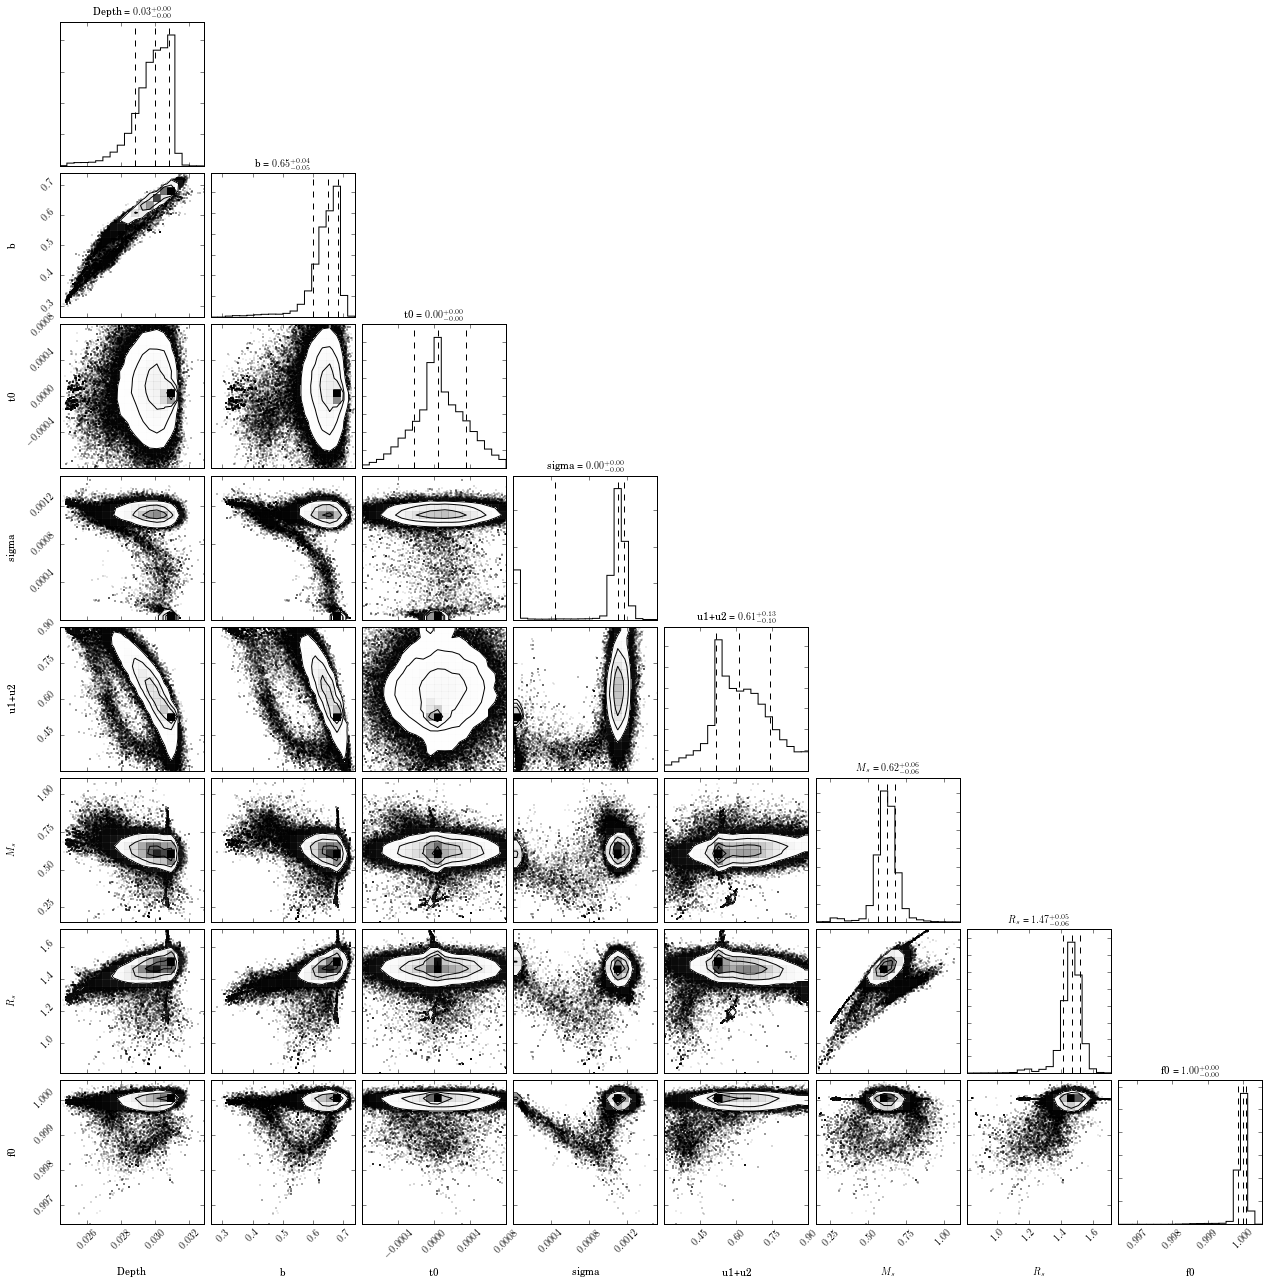

(27.715779956841608, 1.1484877876291222, 1.4358482979641352)
(0.11198871110265428, 0.0031555898857103248, 0.0034390273949204825)
Analysis of: 206061524
Model parameters:
      Depth: 0.00766147962943
      Impact parameter b: 0.416105165293
      Initial transit time: 0.000307696972763
      Sigma (additional white noise term): 1.42207493988e-06
      Sum of quadratic LD coefficients: 0.622822726521
      Mass (Earth units): 0.645119729183
      Radius (Earth units): 0.631321190683
      Out-of-transit Flux: 1.00021717022

Running MCMC...
Done.


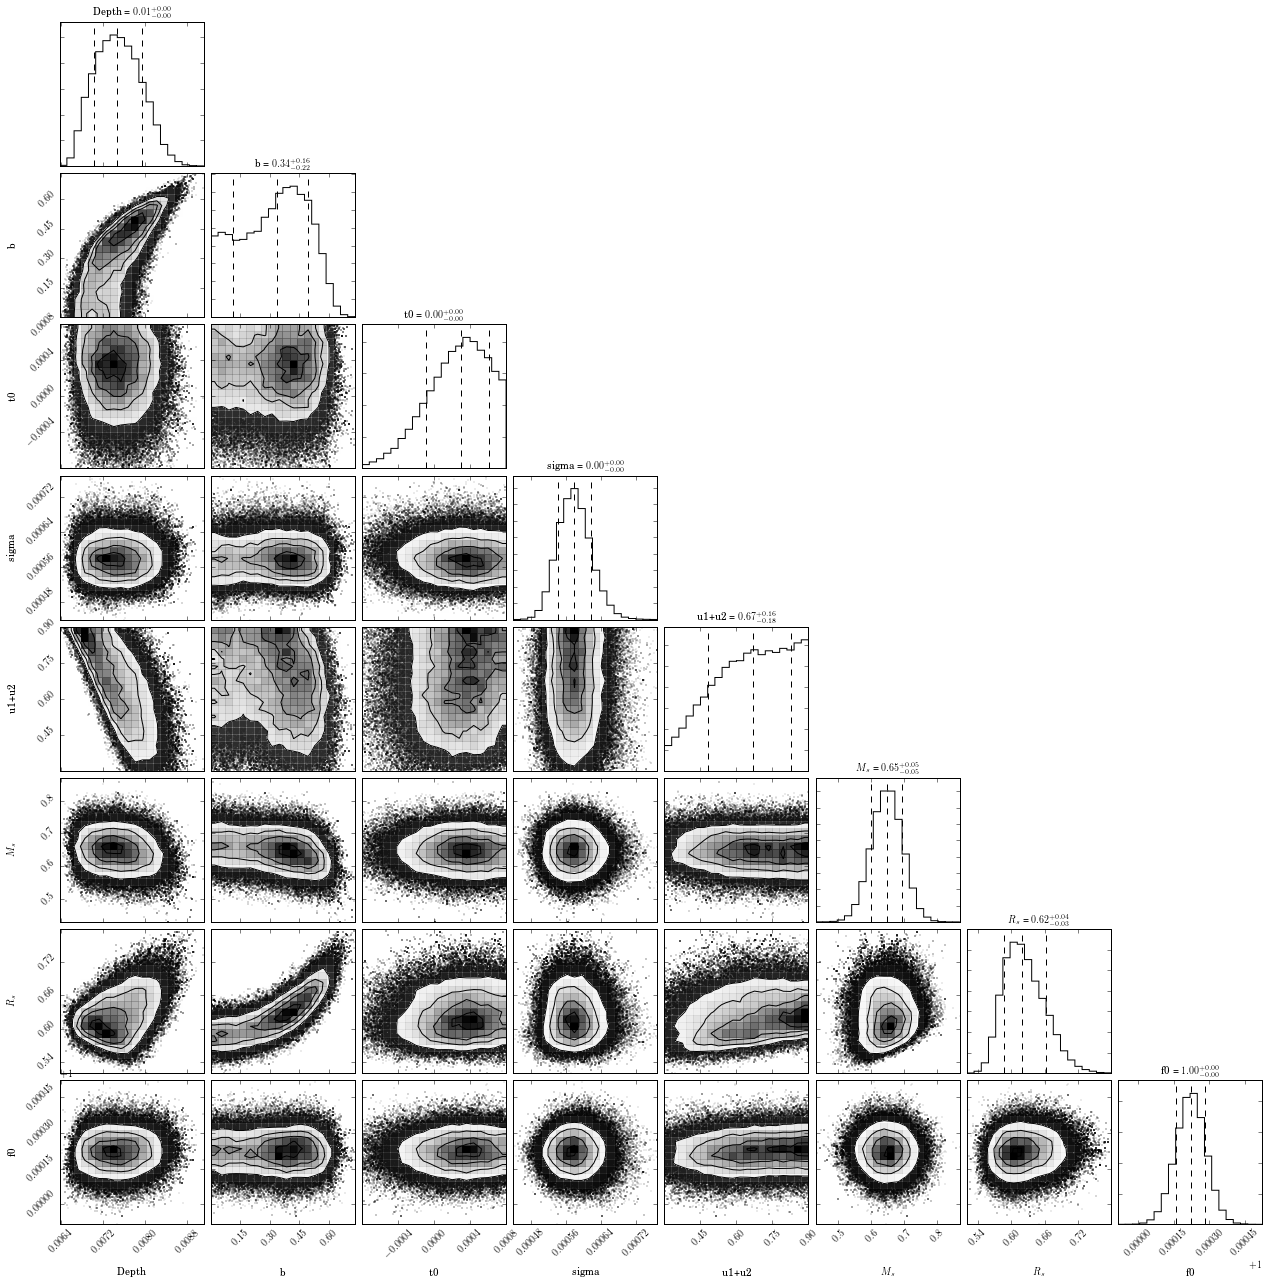

(5.8065873545929581, 0.56287681247107635, 0.34976950351769442)
(0.052165560458623104, 0.0040188501004833413, 0.0026752010788122366)
Analysis of: 206082454
Model parameters:
      Depth: 0.00110192226832
      Impact parameter b: 0.420207305488
      Initial transit time: -2.31301408503e-05
      Sigma (additional white noise term): 3.95965820871e-09
      Sum of quadratic LD coefficients: 0.65223981579
      Mass (Earth units): 0.899909454859
      Radius (Earth units): 0.891330092743
      Out-of-transit Flux: 1.00008161975

Running MCMC...
Done.


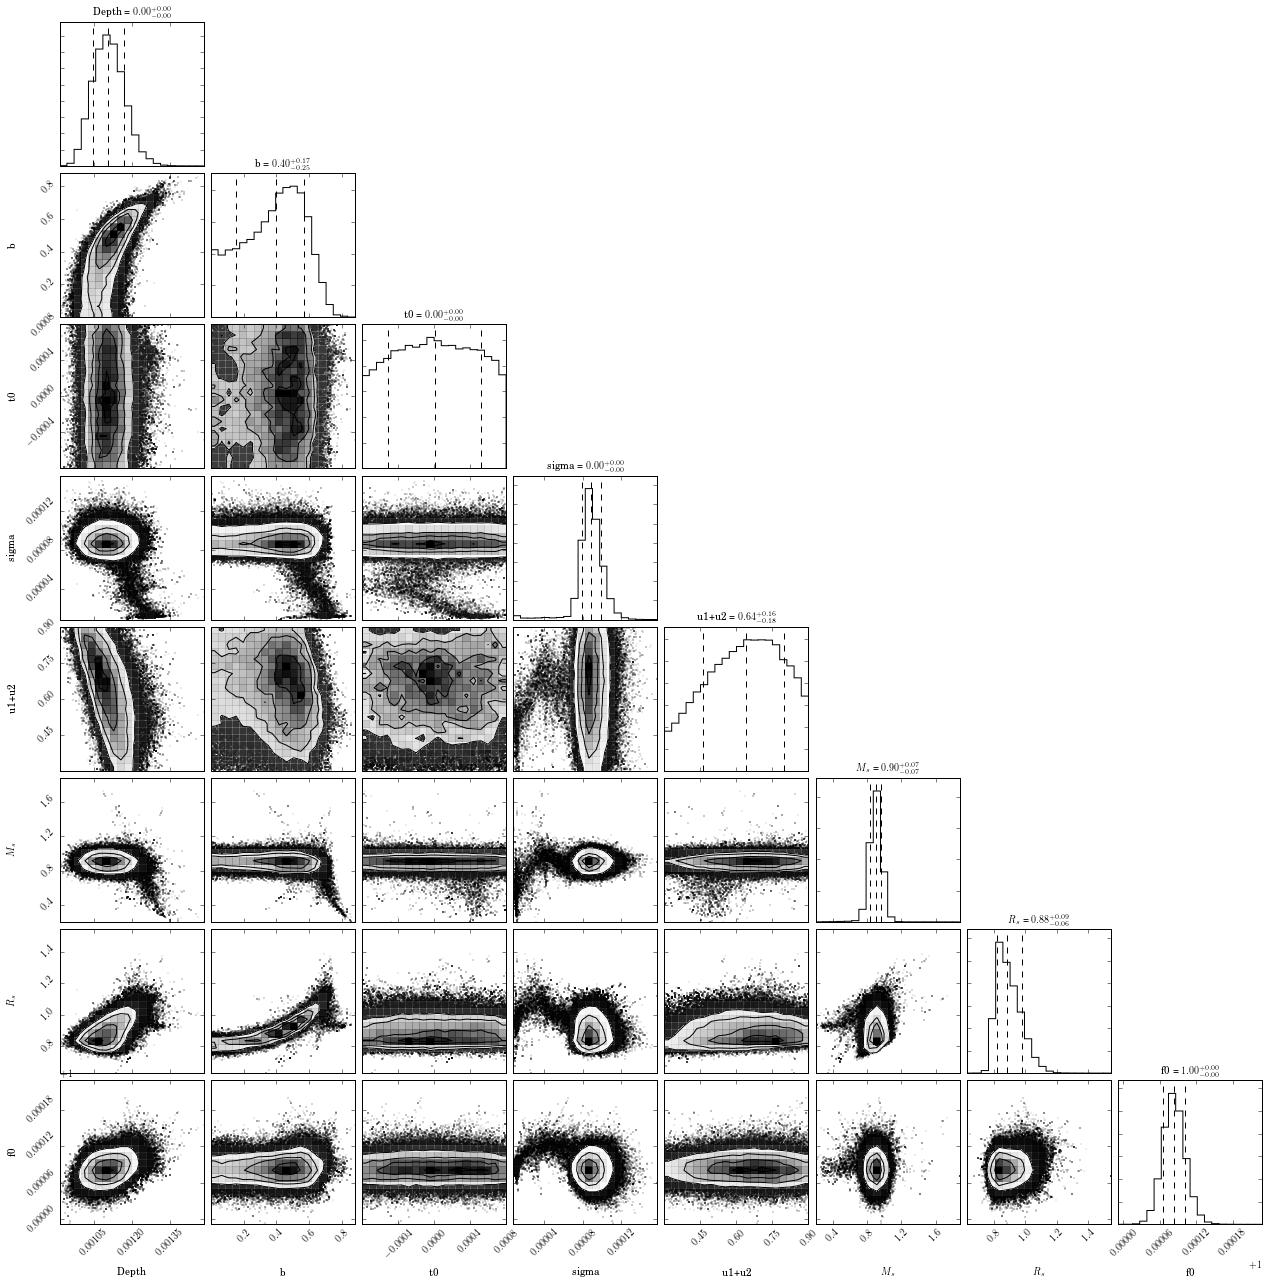

(3.1907788602608758, 0.42891282720971224, 0.26408838617797947)
(0.022721693673040916, 0.0025180023753743827, 0.0015804840828789433)
Analysis of: 206155547
Model parameters:
      Depth: 0.0207243872768
      Impact parameter b: 0.37720677711
      Initial transit time: 0.000335009819053
      Sigma (additional white noise term): 1.85582997885e-06
      Sum of quadratic LD coefficients: 0.616184911382
      Mass (Earth units): 1.18618130522
      Radius (Earth units): 1.14615869776
      Out-of-transit Flux: 0.999959378164

Running MCMC...
Done.


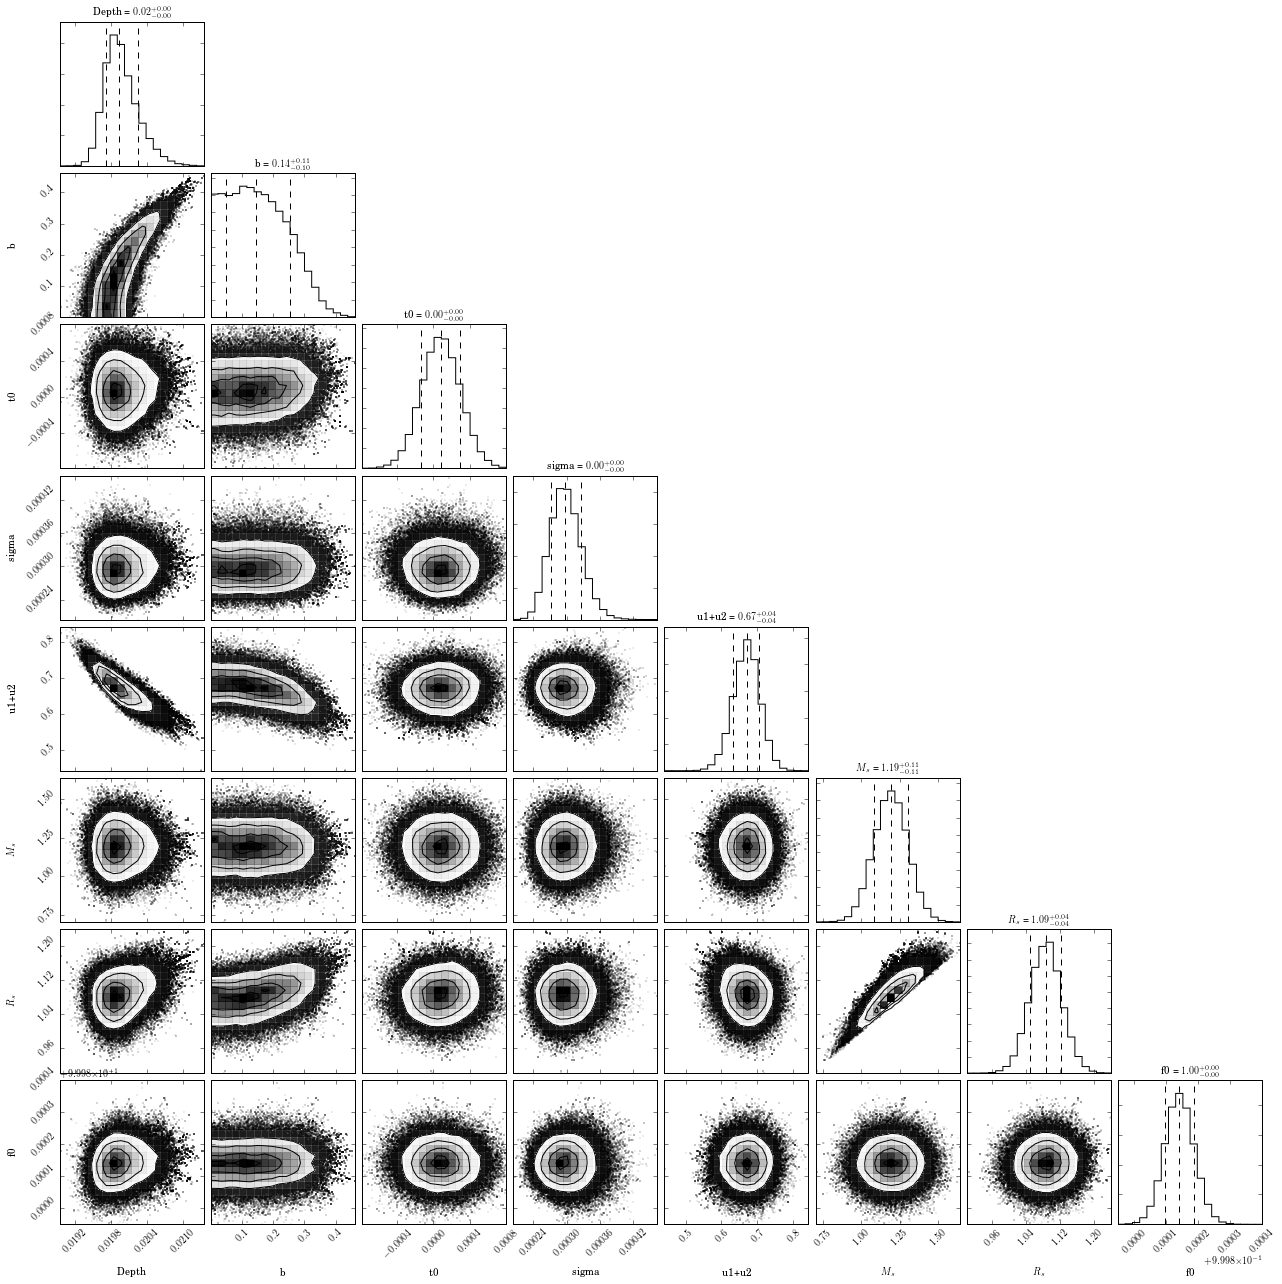

(16.721102739005843, 0.61839189695191976, 0.59673223803111597)
(0.028846152145929074, 0.00058488858753788509, 0.0002738003470895492)
Analysis of: 206245553
Model parameters:
      Depth: 0.00048470405
      Impact parameter b: 0.23086941042
      Initial transit time: 0.00169254035
      Sigma (additional white noise term): 5.958299e-05
      Sum of quadratic LD coefficients: 0.71250485635
      Mass (Earth units): 1.05595441064
      Radius (Earth units): 1.01999788294
      Out-of-transit Flux: 0.99999885997

Running MCMC...
Done.


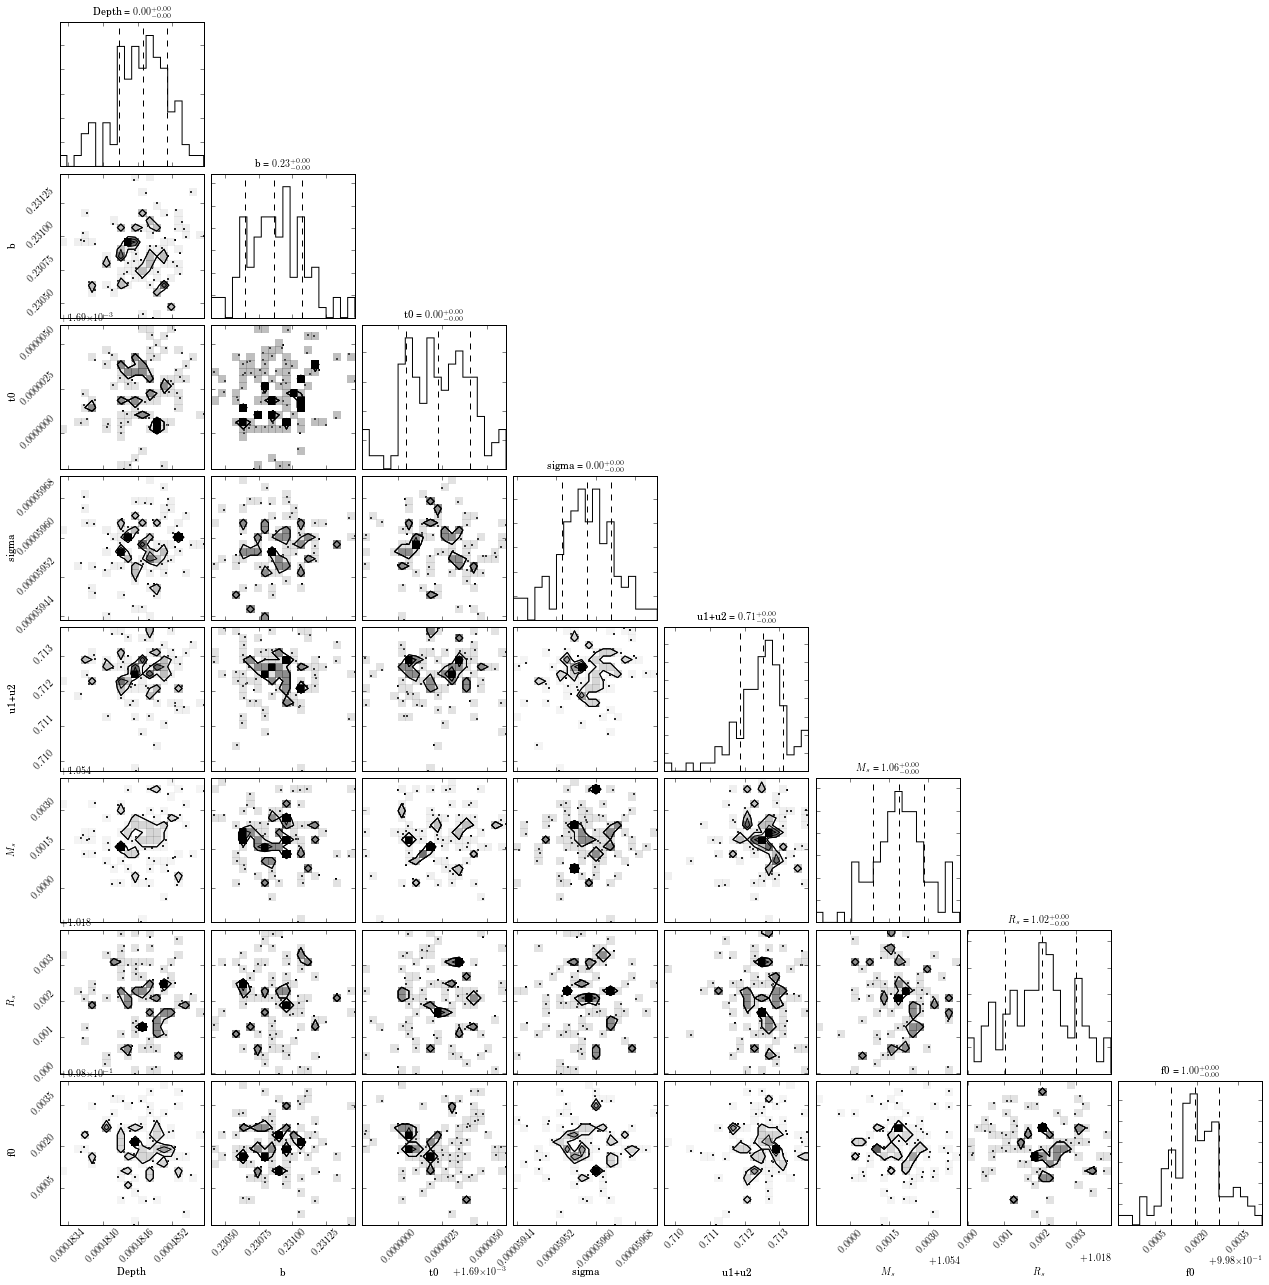

(2.4488248034628528, 0.0021127803761622488, 0.0025963751222568554)
(0.06219891906652171, 5.8183619678048304e-05, 6.8123832443346688e-05)


In [127]:
G = 6.6730e-11


for star in final_targets:   
    
    print "Analysis of:", star.name
    print "Model parameters:" 
    print "      Depth:", star.optimize4[0]
    print "      Impact parameter b:", star.optimize4[1]
    print "      Initial transit time:", star.optimize4[2]
    print "      Sigma (additional white noise term):", star.optimize4[3]
    print "      Sum of quadratic LD coefficients:", star.optimize4[4]
    print "      Mass (Earth units):", star.optimize4[5]
    print "      Radius (Earth units):", star.optimize4[6]
    print "      Out-of-transit Flux:", star.optimize4[7]
    print ""
                               
    allfixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
        
    ndim = 8
    nwalkers = 100
        
    # Choose an initial set of positions for the walkers.
    #p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]
    p0 = [star.optimize4*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

    # Initialize the sampler with the chosen specs.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                    args = (star.dt, star.f_trans, 0.01*star.error_foldedLC, allfixed))
        
    # Run 100 steps as a burn-in.
    pos, prob, state = sampler.run_mcmc(p0, 100)
    
    # Reset the chain to remove the burn-in samples.
    sampler.reset()
    
    # Starting from the final position in the burn-in chain, sample for 2000 steps.
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, 5000, rstate0=state)
    print("Done.")
            
    # Make the triangle plot.
    burnin = 500 #Burn in portion to remove (currently %10)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    
    plt.figure()
    fig = corner.corner(samples, labels=["Depth", "b", "t0", "sigma", "u1+u2", "$M_s$","$R_s$", "f0"], 
                        quantiles = [0.16, 0.5, 0.84], 
                        show_titles = True, title_args={"fontsize": 13})
        
    plt.show()
    fig.savefig('4_'+star.name+'_corner.png')      
    
        
    """
        ndim, nwalkers = 8, 250
        st = 5000
        # Choose an initial set of positions for the walkers.
        pos = [star.optimize4*(1+1e-5*np.random.randn(ndim)) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (star.dt, star.f_trans, 0.01*star.error_foldedLC, allfixed))
        
        sampler.run_mcmc(pos, st)
        samples = sampler.chain[:, 500:, :].reshape((-1, ndim)) 
        
        #Create corner plot
        plt.figure()
        figure = corner.corner(samples, 
                               labels=["Depth", "b", "t0", "sigma", "u1+u2", "$M_s$","$R_s$", "f0"], 
                               quantiles = [0.16, 0.5, 0.84], 
                               show_titles = True, title_args={"fontsize": 13})

        figure.gca().annotate('Star '+star.name, xy = (0.5, 1.0), xycoords="figure fraction", xytext=(0, -5), textcoords="offset points", ha = "center", va="top")

        plt.show()
        fig.savefig('4_'+star.name+'_corner.png')        
    """
        
    #Calculates the uncertainties based on the 16, 50th, and 84th percentiles of
    #the samples in the marginalized distributions.         

    samples[:, 3] = np.sqrt(samples[:, 3]**2 + 0.01*star.error_foldedLC**2) # I added this line so that the reported uncertainty is the full error of the flux (error_foldedLC was just a guess). 
    
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]
    P1 = star.per*24.0*3600.0
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333
    
    depth_mcmc, b_mcmc, t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.84, 50, 84.16], axis=0)))

    v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    
    v = np.percentile(r_asamp, [16, 50, 84], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

    print planetrad_mcmc # The planet radius in units of the Earth's radius and its +- errors.
    print r_a_mcmc # The inverse of the scaled semi-major axis

    np.savetxt('4_'+star.name+'finalparams.txt', 
                   (depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc, planetrad_mcmc, r_a_mcmc), fmt='%.11f', delimiter='   ', header = """Parameters obtained from fitting the Kepler data. 
                       The 1st column represents the 50% percentile of the MCMC posterior distribution, 
                       whereas the 2nd and 3rd represent, respectively, the +1 and -1 sigma uncertainty. 
                       In row order, the parameters are: Depth, Impact parameter, time of transit, sigma (full error), 
                       Sum of LD coefficients, Mass of the star in Earth units, Radius of the star in  earth units (gaussian priors on both), 
                       out of eclipse flux, Planet radius (Earth units), R_s/a (Inverse of scaled semi-major axis)""")